In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.getcwd()+"/split_step_fourier.py")

import split_step_fourier

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

Text(0.5, 1.0, 'Impulse Responses')

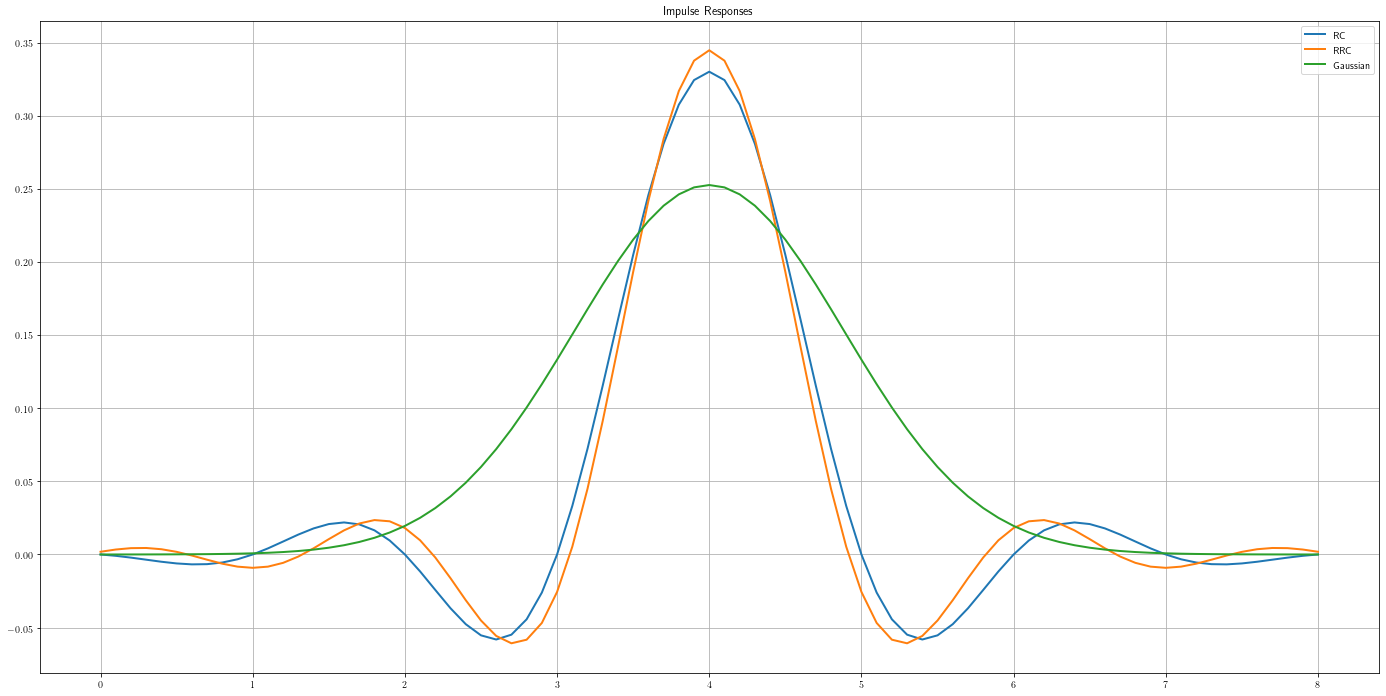

In [2]:
# parameters of the filters
f_symbol = 1.0  # sample rate (Baud)
n_up = 10 # samples per symbol (>1 => oversampling)

r_rc = .33
r_rrc = .33
r_gaussian = 0.8

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

t_rc, rc = split_step_fourier.get_rc_ir( syms_per_filt, r_rc, f_symbol, n_up )
t_rrc, rrc = split_step_fourier.get_rrc_ir( syms_per_filt, r_rrc, f_symbol, n_up )
t_gaussian, gaussian = split_step_fourier.get_gaussian_ir( syms_per_filt, r_gaussian, f_symbol, n_up )

matplotlib.rc('figure', figsize=(24, 12) )

plt.plot( t_rc, rc, linewidth=2.0, label='RC' )
plt.plot( t_rrc, rrc, linewidth=2.0, label='RRC' )
plt.plot( t_gaussian, gaussian, linewidth=2.0, label='Gaussian' )

plt.grid( True )
plt.legend( loc='upper right' )
plt.title( 'Impulse Responses' )

Text(0.5, 1.0, 'Impulse Responses')

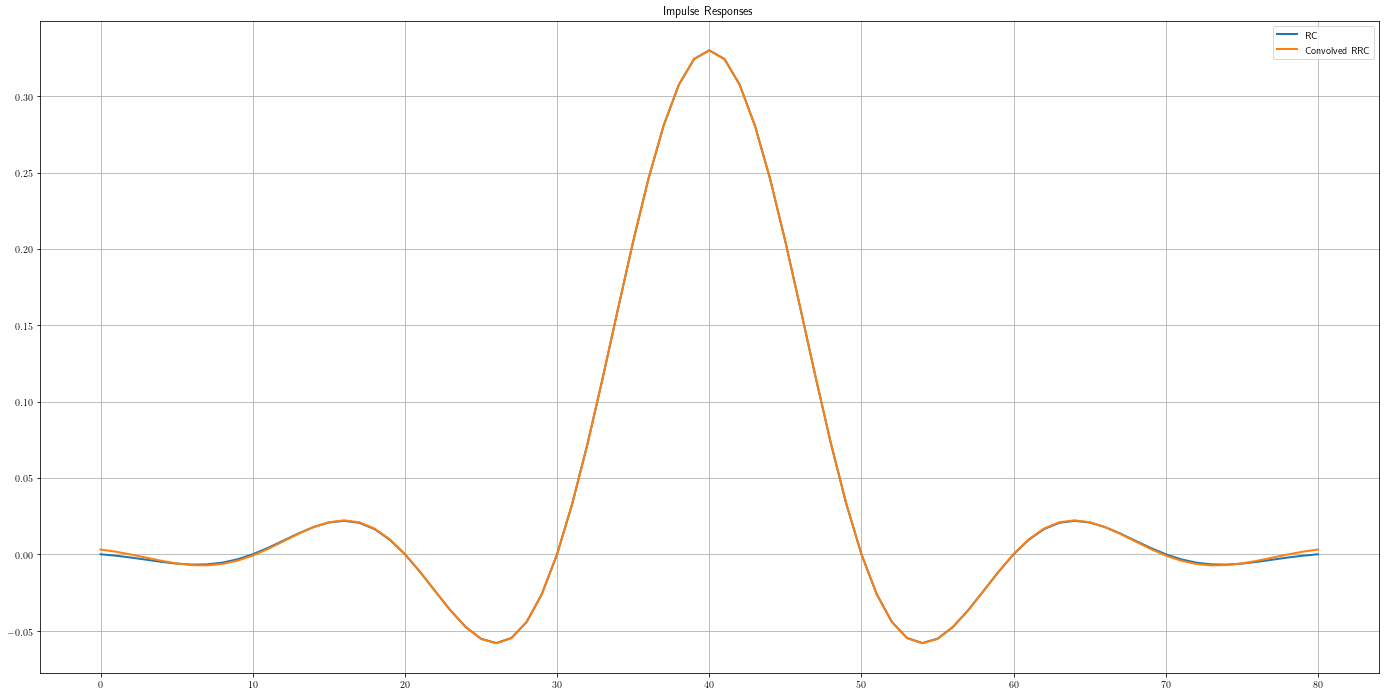

In [3]:
# Comparison of convolved rrc with rc

t_rc, rc = split_step_fourier.get_rc_ir( syms_per_filt, r_rc, f_symbol, n_up )
t_rrc, rrc = split_step_fourier.get_rrc_ir( syms_per_filt, r_rrc, f_symbol, n_up )

rrc_convolved = np.convolve(rrc, rrc, mode='same')
rrc_convolved /= np.linalg.norm(rrc_convolved)

matplotlib.rc('figure', figsize=(24, 12) )

plt.plot( rc, linewidth=2.0, label='RC' )
plt.plot( rrc_convolved, linewidth=2.0, label='Convolved RRC')

plt.grid( True )
plt.legend( loc='upper right' )
plt.title( 'Impulse Responses' )


Text(0.5, 1.0, 'Pulsformung')

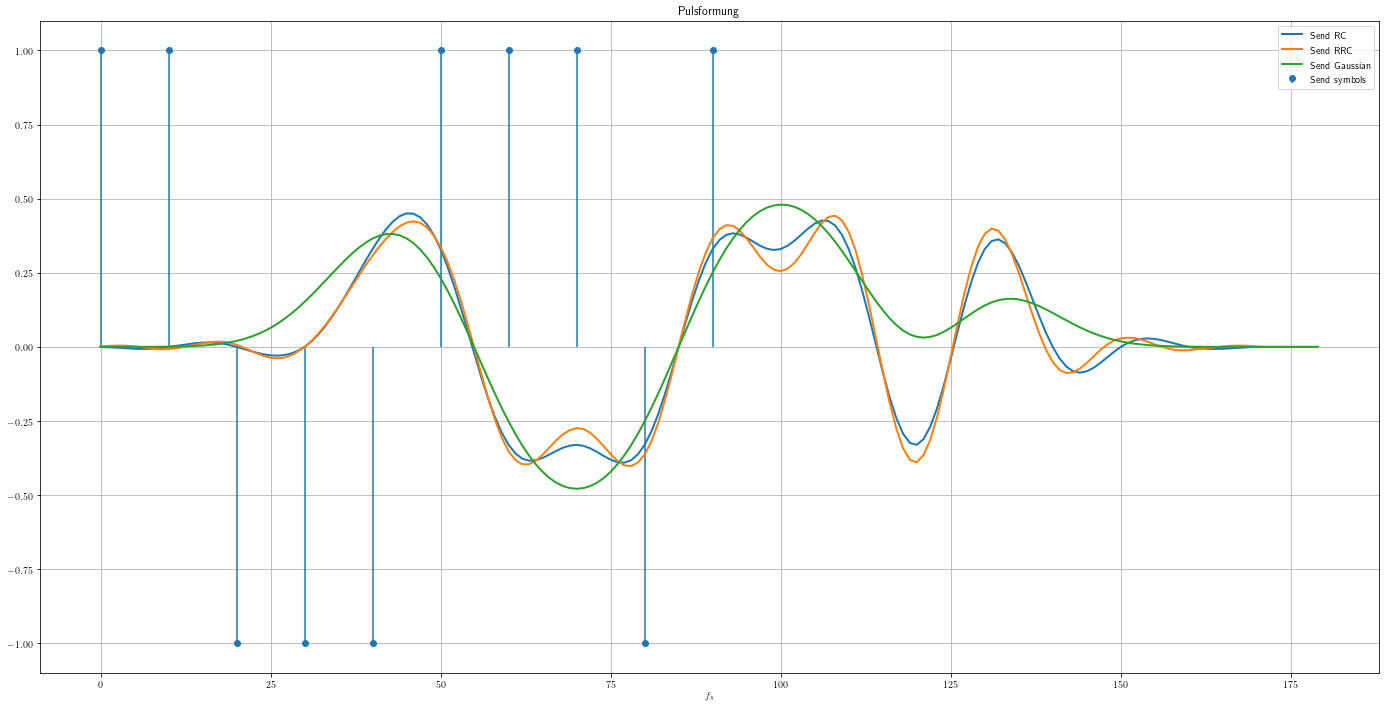

In [4]:
# modulation scheme and constellation points
M = 2
constellation_points = [ -1, 1 ]

n_symbol = 10  # number of symbols

# Signalfolge generieren
send_bits = np.random.randint(M, size=n_symbol)
send_symbols = [ constellation_points[bit] for bit in send_bits ]

send_symbols_up = np.zeros( n_symbol * n_up )
send_symbols_up[ : : n_up ] = send_symbols

send_rc = np.convolve(rc, send_symbols_up)
send_rrc = np.convolve(rrc, send_symbols_up)
send_gaussian = np.convolve(gaussian, send_symbols_up)

matplotlib.rc('figure', figsize=(24, 12) )

plt.plot( send_rc, linewidth=2.0, label='Send RC' )
plt.plot( send_rrc, linewidth=2.0, label='Send RRC' )
plt.plot( send_gaussian, linewidth=2.0, label='Send Gaussian' )
plt.stem( np.arange(n_symbol*n_up, step=n_up), send_symbols, label='Send symbols', use_line_collection=True, basefmt=' ')

plt.grid( True )
plt.ylim(-1.1, 1.1)
plt.xlabel('$f_s$')
plt.legend( loc='upper right' )
plt.title( 'Pulsformung' )
